# Workflow for processing Gawler - 11OCT18 - Landsat 8 - VIS-NIR

In [1]:
import time
start_time = time.time()

import numpy as np

#
# Set up input and output directories
#
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Gawler/11OCT18/'
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/GAW-11OCT18-LS8-VIS-NIR/'

#
# field_data is in the format: 'Field Site Name', 'Date', 'Site number', 'Satellite Name', 'Panel origin', 'Reflectance/Radiance'.
# and 'Radiance'/'Reflectance'.
# NOTE: Satellite name should be one of: 'Landsat8', 'Sentinel2a', or 'Sentinel2b'.
#
field_data = ['GAW', '11OCT18', 'VIS-NIR', 'Landsat8', 'GA_Panel', 'Reflectance', '']

#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
bad_grounds = []
bad_pans = []

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 2

#
# Calculated BRDF data
#
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.06688400000000001, 0.017280000000000004, 0.011784000000000001],
                          ['band11', 0.258872, 0.10949600000000001, 0.033728],
                          ['band12', 0.196324, 0.025404, 0.037880000000000004],
                          ['band2', 0.06688400000000001, 0.017280000000000004, 0.011784000000000001],
                          ['band3', 0.118236, 0.043216000000000004, 0.021136000000000002],
                          ['band4', 0.129284, 0.034264, 0.025076],
                          ['band5', 0.129284, 0.034264, 0.025076],
                          ['band6', 0.129284, 0.034264, 0.025076],
                          ['band7', 0.285624, 0.21953600000000004, 0.016972],
                          ['band8', 0.285624, 0.21953600000000004, 0.016972],
                          ['band8a', 0.285624, 0.21953600000000004, 0.016972],
                         ])

#
# plot_scale defines the extent of the axes in the final two plots in the workflow.
# A scale from 0-1 means no reflectance to perfect reflectance. Typically, dark sites
# will range from 0-0.3, whereas bright sites will be between 0-1.
#
plot_scale = [0.0, 1.0, 0.0, 1.0]

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
# ORIGINAL Corners = [-34.599523, 138.740913, -34.599486, 138.740336, -34.599063, 138.740903, -34.599035, 138.740359] 
Corners = [-34.599523, 138.740640, -34.599486, 138.740063, -34.599063, 138.740630, -34.599035, 138.740086] 
RockWalk = True
StartCorner = 'NW'

In [2]:
import matplotlib.pyplot as plt
import matplotlib

#
# Astropy is used to determine the Solar angle
#
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u
import sys
sys.path.append("..")

import datacube

from CalVal import *

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['savefig.dpi'] = 300

In [3]:
#######################################
# LINES BELOW SHOULD REMAIN UNCHANGED #
#######################################
#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
if field_data[5] == 'Radiance':
    suffix = 'asd.rad.txt'
else: 
    suffix = 'asd.ref.txt'

panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Panels/'

if field_data[4] == 'GA_Panel':
    in_panel = 'ga_panel1_jan_2018.txt'
elif field_data[4] == 'CSIRO_Panel':
    in_panel = 'csiro_panel.txt'
elif field_data[4] == 'UA_Panel':
    in_panel = 'ua_panel.txt'
elif field_data[4] == 'UOW_Panel':
    in_panel = 'uow_panel.txt'
elif field_data[4] == 'UQ_Panel':
    in_panel = 'uq_panel.txt'
elif field_data[4] == 'CSIRO_VIC_Panel':
    in_panel = 'csiro_vic_panel.txt'
else:
    nopanel = '***PANEL NAME NOT KNOWN***'
    print(nopanel)

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Start Figure numbering at 1
#
fignum = 1

### Define 'alldata' as the dataframe that contains all the raw spectra.
Show the first wavelength of every spectrum, so that the data integrity can be checked.

In [4]:
alldata = LoadData.load_from_dir(indir, suffix, firstGoodLine, Corners)

alldata[alldata['Wavelength']==350]

,Wavelength,radiance,filename,date_saved,Latitude,Longitude,Line,Spec_number,Inst_number
25,350,0.007870,line100000.asd.ref,2018-10-11 09:19:42,-34.599523,138.74064,1,0,1496/1\n
25,350,0.012409,line100001.asd.ref,2018-10-11 09:20:00,-34.599523,138.74064,1,1,1496/1\n
25,350,0.012268,line100002.asd.ref,2018-10-11 09:20:03,-34.599523,138.74064,1,2,1496/1\n
25,350,0.012386,line100003.asd.ref,2018-10-11 09:20:07,-34.599523,138.74064,1,3,1496/1\n
25,350,0.012945,line100004.asd.ref,2018-10-11 09:20:10,-34.599523,138.74064,1,4,1496/1\n
25,350,0.013433,line100005.asd.ref,2018-10-11 09:20:16,-34.599523,138.74064,1,5,1496/1\n
25,350,0.013424,line100006.asd.ref,2018-10-11 09:20:23,-34.599523,138.74064,1,6,1496/1\n
25,350,0.011914,line100007.asd.ref,2018-10-11 09:20:26,-34.599523,138.74064,1,7,1496/1\n
25,350,0.015020,line100008.asd.ref,2018-10-11 09:20:30,-34.599523,138.74064,1,8,1496/1\n
25,350,0.014665,line100009.asd.ref,2018-10-11 09:20:49,-34.599523,138.74064,1,9,1496/1\n


### Print out time stamp and coordinate extent for BRDF correction

The time stamp and Lat/Long extents are required to calculate the BRDF correction, used below.

In order to calculate the BRF correction, the following method is used:

<OL>
    <LI>Run the print statements in the cell below.</LI>
    <LI>Copy and paste the output into a VDI terminal window</LI>
    <LI>Copy and paste the resultant VDI output into the BRDF calculation cell, writing over the similar text.</LI>
</OL>

NOTE: This works assuming that the BRDF code is in the current directory.


In [5]:
PrintBRDF.print_brdf(alldata, field_data)

#################################################################################
# Copy and paste the following into a terminal window on VDI for Landsat 8 data #
#################################################################################

source module.sh
sed -i "34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('2018-10-11 09:19:42'))/" retrieve_brdf.py
sed -i "37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(138.74064, -34.599523, 138.74064, -34.599523)]})/" retrieve_brdf.py
python retrieve_brdf.py > temp.txt ; awk -f format_Sent.awk temp.txt



### Create dataframes for all/good/bad panel spectra.

For the bad panel spectra dataframe, first check to see if bad panels have been defined.<BR>
If not, then don't create anything.

### Create spectral dataframes for all ground spectra and good ground spectra

In [6]:
all_grounds_spec = MakeSpecDF.make_spec_df(alldata, field_data)

# Figure 

### Plot ground spectra (all and good), normalised to the median good spectrum

These plots are used to identify any ground spectra that are bogus.

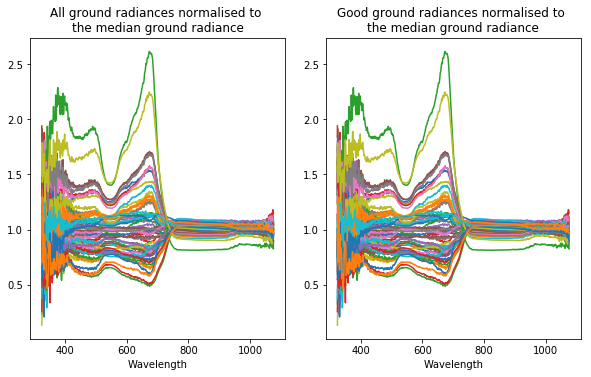

In [7]:
FIG_GroundSpectra.FIG_ground_spectra(all_grounds_spec, all_grounds_spec, output, field_data, fignum)
fignum +=1

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [8]:
SpecRename.spec_rename(all_grounds_spec, all_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec, field_data)

### Create dataframe with Reflectances

### Test for reflectances
Test field_data to see if the data were saved as reflectances. If so, bypass all the panelling workflow.

In [9]:
if field_data[5] == 'Reflectance':
    all_refls = all_grounds_spec

### Apply weighted band responses to all reflectances

In [10]:
for i in range(1076, 2501):
    all_refls.loc[i] = all_refls.loc[1075]
for i in range(325, 350):
    all_refls.drop(i, inplace=True)

In [11]:
ls_result_df, s2_result_df, ls_band, s2_band = ApplyWeights.apply_weights(f_name, all_refls, sat_resp, field_data)

### Reformat band reflectances and apply to dataframe "ground_bands"

In [12]:
ls_ground_bands = ReformatDF.reformat_df(alldata, ls_result_df)
s2_ground_bands = ReformatDF.reformat_df(alldata, s2_result_df)

# Figure 

### Plot band reflectances

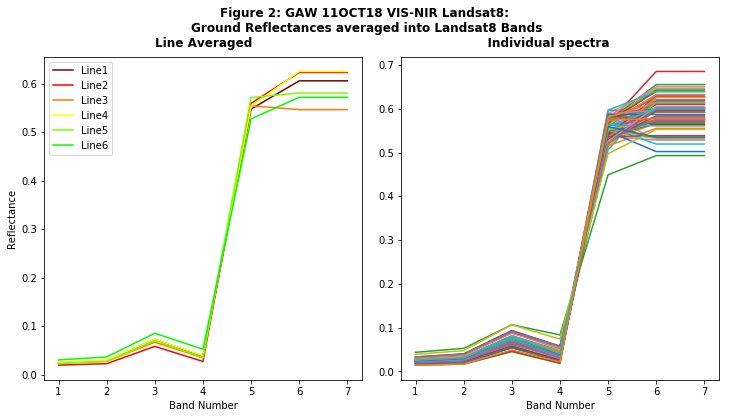

In [13]:
FIG_BandReflectances.FIG_band_reflectances(ls_ground_bands, ls_result_df, ls_band, s2_ground_bands, s2_result_df, s2_band, colpac, output, field_data, fignum)

fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

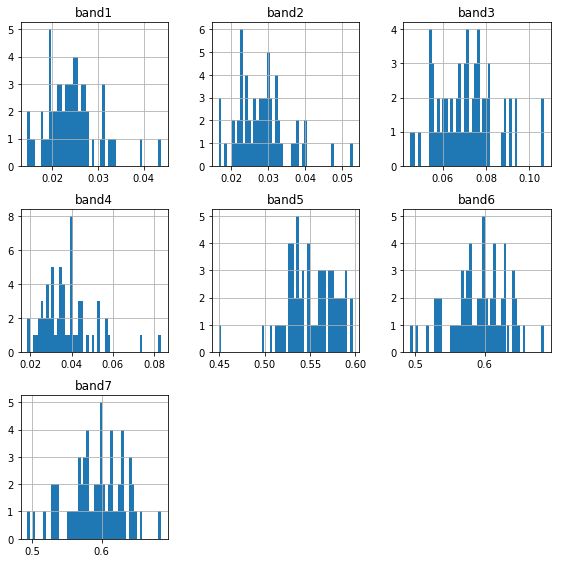

In [14]:
FIG_SpecHistogram.FIG_spec_histogram(ls_ground_bands, s2_ground_bands, output, field_data, fignum)
fignum += 1

### Outlying ground spectra

Display the spectra with maximum and minimum values. These can be compared to the histograms above<BR>
    to identify any outlying spectra that need to be identified as bad ground spectra.

In [15]:
OutlyingSpec.outlying_spec(ls_ground_bands, s2_ground_bands, field_data)

Maximum value found in: line600001.asd.ref 
 band1    0.043786
band2    0.052757
band3    0.106733
band4    0.083459
band5    0.449135
band6    0.493132
band7    0.493132
Name: 52, dtype: float64 
Minimum value found in: line600010.asd.ref 
 band1    0.014500
band2    0.017051
band3    0.049276
band4    0.021610
band5    0.573755
band6    0.577771
band7    0.577771
Name: 61, dtype: float64


### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [16]:
from CalVal.SolarAngle import solang
ls_ground_bands['Solar_angle'] = ls_ground_bands.apply(solang, axis=1)
s2_ground_bands['Solar_angle'] = s2_ground_bands.apply(solang, axis=1)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [17]:
ls_ground_brdf, s2_ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, ls_ground_bands, s2_ground_bands, field_data)

### Choose bands for Landsat 8 and Sentinel satellite data

In [18]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

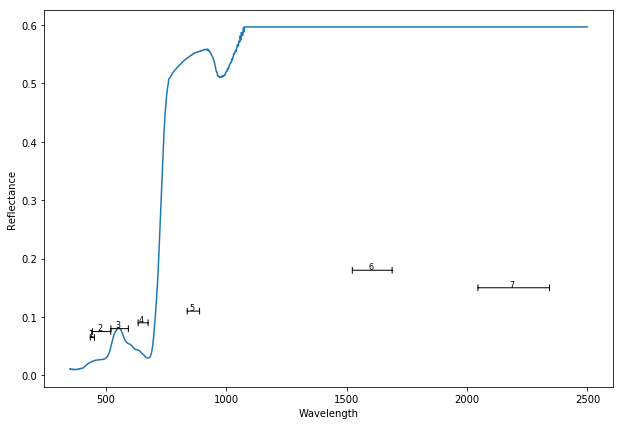

In [19]:
FIG_BandExtents.FIG_band_extents(all_refls, band_min, band_max, output, field_data, fignum)
fignum += 1

### Fudge GPS locations if none exist

In [20]:
ls_ground_brdf = FudgeGPS.fudge_gps(ls_ground_brdf, Corners, RockWalk, StartCorner)
s2_ground_brdf = FudgeGPS.fudge_gps(s2_ground_brdf, Corners, RockWalk, StartCorner)

No good GPS Coordinates found, fudging...
No good GPS Coordinates found, fudging...


### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.

In [21]:
ls_sat_array, ls_sat_bigarray, s2_sat_array, s2_sat_bigarray, ls8_usgs_array, ls8_usgs_bigarray, solar_zenith,\
ls_query, s2_query, ls_dc, s2_dc, ls_ground_WSbrdf = QueryAndCreate.query_and_create(ls_ground_brdf, s2_ground_brdf, ls_ground_bands, s2_ground_bands, field_data, Corners, RockWalk, StartCorner)

No good GPS Coordinates found, fudging...


# Figure 

### Plot relative locations of field and satellite data

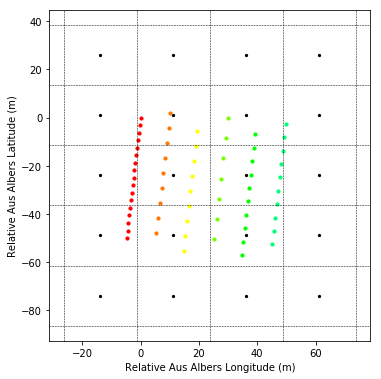

In [22]:
ls_xloc, s2_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ls_ground_brdf, s2_ground_brdf, ls_sat_array, s2_sat_array, colpac, output, field_data, fignum)
fignum +=1

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [23]:
ls_field_array, s2_field_array = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)
ls_field_WSarray, dummy = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)

# Figure 

### Plot large-area context RGB array for Satellite data

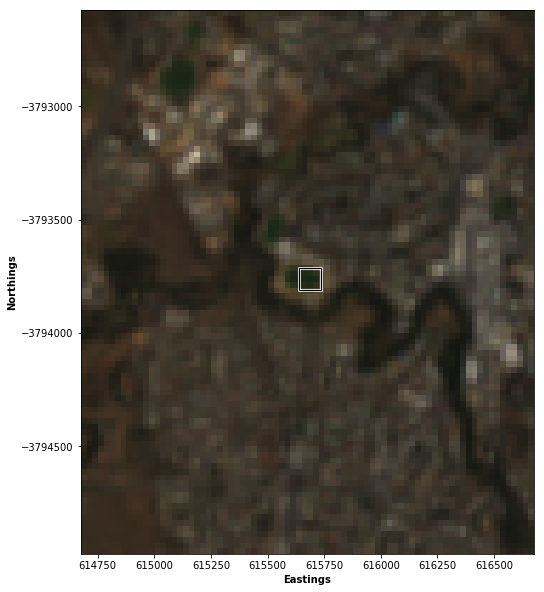

In [24]:
if field_data[3] == 'Landsat8':
    FIG_SatBigRGB.FIG_sat_bigRGB(ls_sat_array, ls_sat_bigarray, output, field_data, fignum)
else:
    FIG_SatBigRGB.FIG_sat_bigRGB(s2_sat_array, s2_sat_bigarray, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Satellite data

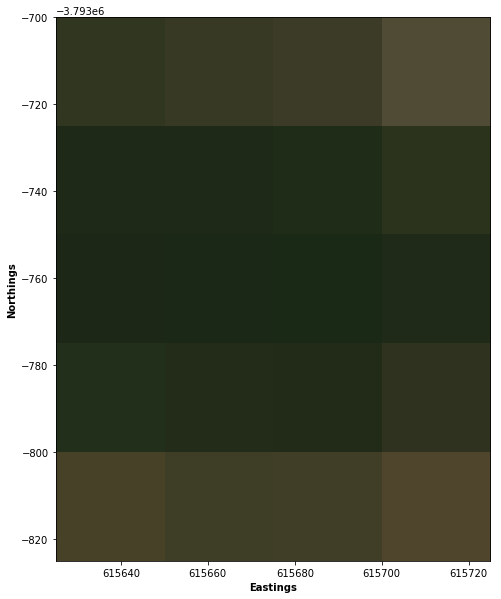

In [25]:
if field_data[3] == 'Landsat8':
    FIG_SatRGB.FIG_sat_RGB(ls_sat_array, output, field_data, fignum)
else:
    FIG_SatRGB.FIG_sat_RGB(s2_sat_array, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Field data

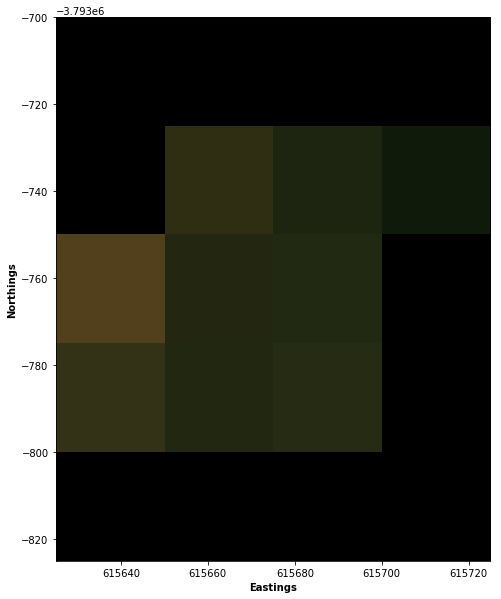

In [26]:
if field_data[3] == 'Landsat8':
    FIG_FieldRGB.FIG_field_RGB(ls_field_WSarray, output, field_data, fignum)
else:
    FIG_FieldRGB.FIG_field_RGB(s2_field_array, output, field_data, fignum)
fignum += 1

## Figure
### Variance of satellite data

Band-by-band plots of the ratio of satellite data, divided by the mean, for each band are shown.
The title also lists the min, max and mean variance. Variance is defined as the ratio of the standard
deviation divided by the mean, for each band. The mean variance should typically be less than 5%.

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/_collections_abc.py:761: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for key in self._mapping:


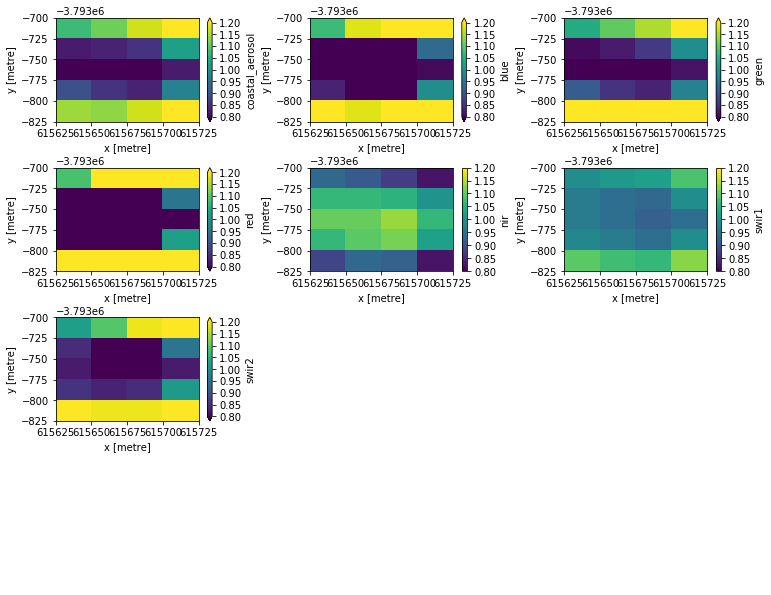

In [27]:
if field_data[3] == 'Landsat8':
    variance = FIG_SatBands.FIG_sat_bands(ls_sat_array, ls_field_WSarray, output, field_data, fignum)
else:
    variance = FIG_SatBands.FIG_sat_bands(s2_sat_array, s2_field_array, output, field_data, fignum)
fignum += 1

# Figure

### Plot ratio arrays for each band

Each panel shows the ratio of satellite/field data.

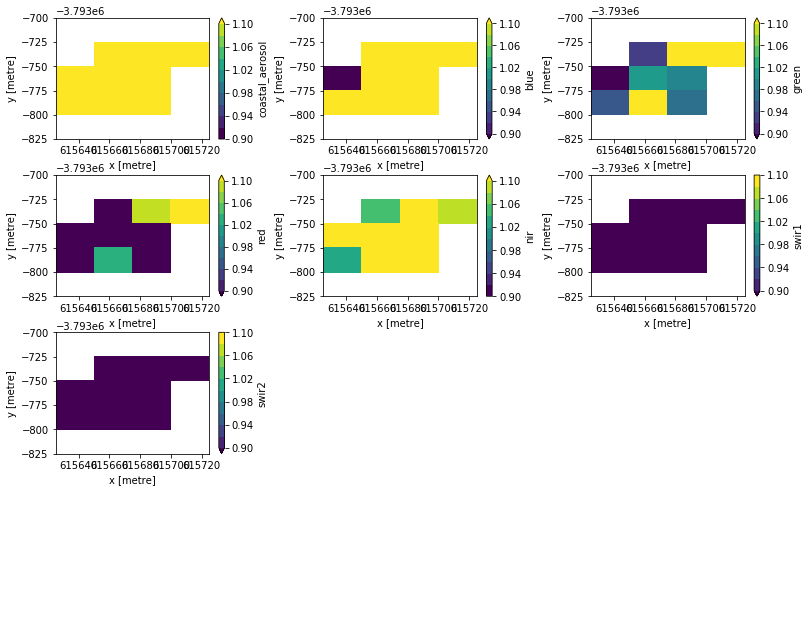

In [28]:
if field_data[3] == 'Landsat8':
    FIG_RatioArrays.FIG_ratio_arrays(ls_sat_array, ls_field_WSarray, output, field_data, fignum)
else:
    FIG_RatioArrays.FIG_ratio_arrays(s2_sat_array, s2_field_array, output, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [29]:
ls_fstat_df, s2_fstat_df = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
ls_fstat_WSdf, dummy = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, field_data)

if field_data[6] == 'USGS':
    ls_fstat_usgs_df, dummy = CreateStats.create_stats(ls8_usgs_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
else:
    ls_fstat_usgs_df = 0

## Create a statistics dataframe, comparing satellite and field data,
for only those satellite pixels which overlap with at least one field data position.

In [30]:
ls_finner_df, s2_finner_df = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_array, s2_field_array, ls_ground_brdf, s2_ground_brdf, ls_fstat_df, s2_fstat_df, field_data)
ls_finner_WSdf, dummy = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_WSarray, s2_field_array, ls_ground_WSbrdf, s2_ground_brdf, ls_fstat_WSdf, s2_fstat_df, field_data)

# Figure

### Plot comparison spectra of satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the satellite and field data, based on the standard deviation of the pixels
within the field. The black line shows the satellite data, which has been averaged over all pixels that satisfy the Datacube query ie. all pixels shown in Figure 11. The orange line shows satellite data which has been averaged over only those pixels that overlap with at least one field measurement.

In [31]:
fstat_df.drop(['Band6', 'Band7'], inplace=True)
finner_df.drop(['Band6', 'Band7'], inplace=True)

NameError: name 'fstat_df' is not defined

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(ls_sat_array, ls_fstat_WSdf, ls_finner_WSdf, output, field_data, fignum)
else:
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(s2_sat_array, s2_fstat_df, s2_finner_df, output, field_data, fignum)
fignum += 1

In [ ]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldBands.FIG_sat_field_bands(ls_sat_array, ls_fstat_WSdf, ls_finner_WSdf, output, field_data, fignum)
else:
    FIG_SatFieldBands.FIG_sat_field_bands(s2_sat_array, s2_fstat_df, s2_finner_df, output, field_data, fignum)
fignum += 1

# Figure

### Comparison plot of Field and satellite data

Plot shows a pixel-by-pixel comparison of all pixels where field data exists.<BR> 
Different band data are shown in different colours and different symbols.

In [ ]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import csv, glob, sys, os, re, shutil
import math
import pyproj

import datacube
import DEAPlotting
import matplotlib.pyplot as plt


#
# # Figure 
#
### Comparison plot of Field and satellite data
#
# Plot shows a pixel-by-pixel comparison of all pixels where field data exists.
# Different band data are shown in different colours and different symbols.
#
def FIG_sat_field_scatter_compare(sat_array, field_array, plot_scale, output, field_data, fignum):

    #fig_title = 'Figure '+str(fignum)+': '+field_data[0]+' '+field_data[1]+' '+field_data[2]+' '+field_data[3]
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.0, 6.0))
    #fig.suptitle(fig_title+':\nPixel by pixel comparison of field and satellite data', fontweight='bold')
    plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

    plt.xlim(plot_scale[0], plot_scale[1])
    plt.ylim(plot_scale[2], plot_scale[3])
    p1, p2 = [-1, 2], [-1, 2]
    plt.plot(p1, p2, marker='o')
    plt.xlabel('Field Reflectance per pixel', fontweight='bold')
    plt.ylabel('Satellite Reflectance per pixel', fontweight='bold')

    if field_data[3] == 'Landsat8':
        plt.scatter(field_array.coastal_aerosol[0]/10000, sat_array.coastal_aerosol[0]/10000, marker='o', facecolors='none', edgecolors='red')
        plt.scatter(field_array.blue[0]/10000, sat_array.blue[0]/10000, marker='^', facecolors='none', edgecolors='orange')
        plt.scatter(field_array.green[0]/10000, sat_array.green[0]/10000, marker='s', facecolors='none', edgecolors='yellow')
        plt.scatter(field_array.red[0]/10000, sat_array.red[0]/10000, marker='+', color='green')
        plt.scatter(field_array.nir[0]/10000, sat_array.nir[0]/10000, marker='x', color='blue')
        #plt.scatter(field_array.swir1[0]/10000, sat_array.swir1[0]/10000, marker='D', facecolors='none', edgecolors='darkblue')
        #plt.scatter(field_array.swir2[0]/10000, sat_array.swir2[0]/10000, marker='*', facecolors='none', edgecolors='black')

    elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
        plt.scatter(field_array.nbart_coastal_aerosol[0]/10000, sat_array.nbart_coastal_aerosol[0]/10000, marker='o', facecolors='none', edgecolors='red')
        plt.scatter(field_array.nbart_blue[0]/10000, sat_array.nbart_blue[0]/10000, marker='^', facecolors='none', edgecolors='orange')
        plt.scatter(field_array.nbart_green[0]/10000, sat_array.nbart_green[0]/10000, marker='s', facecolors='none', edgecolors='yellow')
        plt.scatter(field_array.nbart_red[0]/10000, sat_array.nbart_red[0]/10000, marker='+', color='green')
        plt.scatter(field_array.nbart_red_edge_1[0]/10000, sat_array.nbart_red_edge_1[0]/10000, marker='+', color='blue')
        plt.scatter(field_array.nbart_red_edge_2[0]/10000, sat_array.nbart_red_edge_2[0]/10000, marker='+', color='orange')
        plt.scatter(field_array.nbart_red_edge_3[0]/10000, sat_array.nbart_red_edge_3[0]/10000, marker='+', color='red')
        plt.scatter(field_array.nbart_nir_1[0]/10000, sat_array.nbart_nir_1[0]/10000, marker='x', color='blue')
        plt.scatter(field_array.nbart_nir_2[0]/10000, sat_array.nbart_nir_2[0]/10000, marker='x', color='yellow')
        #plt.scatter(field_array.nbart_swir_2[0]/10000, sat_array.nbart_swir_2[0]/10000, marker='D', facecolors='none', edgecolors='darkblue')
        #plt.scatter(field_array.nbart_swir_3[0]/10000, sat_array.nbart_swir_3[0]/10000, marker='*', facecolors='none', edgecolors='black')

    else:
        print('Satellite name should be one of Landsat8 or Sentinel2a/b. I got', field_data[3])

    x_stretch = (plot_scale[1]-plot_scale[0])
    y_stretch = (plot_scale[3]-plot_scale[2])

    if field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.975*y_stretch)+plot_scale[2], marker='o', facecolors='none', edgecolors='red')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.945*y_stretch)+plot_scale[2], marker='^', facecolors='none', edgecolors='orange')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.915*y_stretch)+plot_scale[2], marker='s', facecolors='none', edgecolors='yellow')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.885*y_stretch)+plot_scale[2], marker='+', color='green')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.855*y_stretch)+plot_scale[2], marker='+', color='blue')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.823*y_stretch)+plot_scale[2], marker='+', color='orange')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.793*y_stretch)+plot_scale[2], marker='+', color='red')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.762*y_stretch)+plot_scale[2], marker='x', color='blue')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.731*y_stretch)+plot_scale[2], marker='x', color='yellow')
        #plt.scatter((0.03*x_stretch)+plot_scale[0], (0.698*y_stretch)+plot_scale[2], marker='D', facecolors='none', edgecolors='darkblue')
        #plt.scatter((0.03*x_stretch)+plot_scale[0], (0.665*y_stretch)+plot_scale[2], marker='*', facecolors='none', edgecolors='black')

        plt.figtext(0.175, 0.885, "Band 1 - Coastal Aerosol")
        plt.figtext(0.175, 0.860, "Band 2 - Blue")
        plt.figtext(0.175, 0.835, "Band 3 - Green")
        plt.figtext(0.175, 0.812, "Band 4 - Red")
        plt.figtext(0.175, 0.787, "Band 5 - Red Edge 1")
        plt.figtext(0.175, 0.763, "Band 6 - Red Edge 2")
        plt.figtext(0.175, 0.738, "Band 7 - Red Edge 3")
        plt.figtext(0.175, 0.713, "Band 8 - NIR")
        plt.figtext(0.175, 0.688, "Band 8a - Narrow NIR")
        #plt.figtext(0.175, 0.663, "Band 11 - SWIR 2")
        #plt.figtext(0.175, 0.638, "Band 12 - SWIR 3")

    elif field_data[3] == 'Landsat8':
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.975*y_stretch)+plot_scale[2], marker='o', facecolors='none', edgecolors='red')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.945*y_stretch)+plot_scale[2], marker='^', facecolors='none', edgecolors='orange')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.915*y_stretch)+plot_scale[2], marker='s', facecolors='none', edgecolors='yellow')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.885*y_stretch)+plot_scale[2], marker='+', color='green')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.855*y_stretch)+plot_scale[2], marker='x', color='blue')
        #plt.scatter((0.03*x_stretch)+plot_scale[0], (0.825*y_stretch)+plot_scale[2], marker='D', facecolors='none', edgecolors='darkblue')
        #plt.scatter((0.03*x_stretch)+plot_scale[0], (0.795*y_stretch)+plot_scale[2], marker='*', facecolors='none', edgecolors='black')

        plt.figtext(0.175, 0.885, "Band 1 - Coastal Aerosol")
        plt.figtext(0.175, 0.860, "Band 2 - Blue")
        plt.figtext(0.175, 0.835, "Band 3 - Green")
        plt.figtext(0.175, 0.812, "Band 4 - Red")
        plt.figtext(0.175, 0.787, "Band 5 - NIR")
        #plt.figtext(0.175, 0.763, "Band 6 - SWIR1")
        #plt.figtext(0.175, 0.738, "Band 7 - SWIR2")

    else:
        print('Satellite name should be one of Landsat8 or Sentinel2a/b. I got', field_data[3])

    plt.savefig(output+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'_'+'Fig'+str(fignum)+'_PixelByPixelComparison.png')


FIG_sat_field_scatter_compare(sat_array, field_array, plot_scale, output, field_data, fignum)
fignum += 1

In [ ]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import csv, glob, sys, os, re, shutil
import math
import pyproj

import datacube
import DEAPlotting
import matplotlib.pyplot as plt


#
# # Figure 
#
### Comparison plot of Field and satellite data
#
# Plot shows an averaged comparison of all pixels where field data exists.
# Different band data are shown in different colours and different symbols.
#
def FIG_sat_field_avg_scatter_compare(sat_array, field_array, plot_scale, fstat_df, output, field_data, fignum):

    #fig_title = 'Figure '+str(fignum)+': '+field_data[0]+' '+field_data[1]+' '+field_data[2]+' '+field_data[3]
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.0, 6.0))
    #fig.suptitle(fig_title+':\nAveraged comparison of field and satellite data', fontweight='bold')
    plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

    plt.xlim(plot_scale[0], plot_scale[1])
    plt.ylim(plot_scale[2], plot_scale[3])
    p1, p2 = [-1, 2], [-1, 2]
    plt.plot(p1, p2, marker='o')
    plt.xlabel('Field Reflectance per pixel', fontweight='bold')
    plt.ylabel('Satellite Reflectance per pixel', fontweight='bold')

    if field_data[3] == 'Landsat8':
        plt.errorbar(x=field_array.coastal_aerosol[0].mean()/10000, y=sat_array.coastal_aerosol[0].mean()/10000, xerr=fstat_df.Field_SD['Band1'], yerr=fstat_df.Sat_SD['Band1'], fmt='o', mfc='white', mec='red', color='red', capsize=3)
        plt.errorbar(x=field_array.blue[0].mean()/10000, y=sat_array.blue[0].mean()/10000, xerr=fstat_df.Field_SD['Band2'], yerr=fstat_df.Sat_SD['Band2'], fmt='^', mfc='white', mec='orange', color='orange', capsize=3)
        plt.errorbar(x=field_array.green[0].mean()/10000, y=sat_array.green[0].mean()/10000, xerr=fstat_df.Field_SD['Band3'], yerr=fstat_df.Sat_SD['Band3'], fmt='s', mfc='white', mec='yellow', color='yellow', capsize=3)
        plt.errorbar(x=field_array.red[0].mean()/10000, y=sat_array.red[0].mean()/10000, xerr=fstat_df.Field_SD['Band4'], yerr=fstat_df.Sat_SD['Band4'], fmt='+', mfc='white', mec='green', color='green', capsize=3)
        plt.errorbar(x=field_array.nir[0].mean()/10000, y=sat_array.nir[0].mean()/10000, xerr=fstat_df.Field_SD['Band5'], yerr=fstat_df.Sat_SD['Band5'], fmt='x', mfc='white', mec='blue', color='blue', capsize=3)
        #plt.errorbar(x=field_array.swir1[0].mean()/10000, y=sat_array.swir1[0].mean()/10000, xerr=fstat_df.Field_SD['Band6'], yerr=fstat_df.Sat_SD['Band6'], fmt='D', mfc='white', mec='darkblue', color='darkblue', capsize=3)
        #plt.errorbar(x=field_array.swir2[0].mean()/10000, y=sat_array.swir2[0].mean()/10000, xerr=fstat_df.Field_SD['Band7'], yerr=fstat_df.Sat_SD['Band7'], fmt='*', mfc='white', mec='black', color='black', capsize=3)

    elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
        plt.errorbar(x=field_array.nbart_coastal_aerosol[0].mean()/10000, y=sat_array.nbart_coastal_aerosol[0].mean()/10000, xerr=fstat_df.Field_SD['Band1'], yerr=fstat_df.Sat_SD['Band1'], fmt='o', color='red', mfc='white', mec='red', capsize=3)
        plt.errorbar(x=field_array.nbart_blue[0].mean()/10000, y=sat_array.nbart_blue[0].mean()/10000, xerr=fstat_df.Field_SD['Band2'], yerr=fstat_df.Sat_SD['Band2'], fmt='^', color='orange', mfc='white', mec='orange', capsize=3)
        plt.errorbar(x=field_array.nbart_green[0].mean()/10000, y=sat_array.nbart_green[0].mean()/10000, xerr=fstat_df.Field_SD['Band3'], yerr=fstat_df.Sat_SD['Band3'], fmt='s', color='yellow', mfc='white', mec='yellow', capsize=3)
        plt.errorbar(x=field_array.nbart_red[0].mean()/10000, y=sat_array.nbart_red[0].mean()/10000, xerr=fstat_df.Field_SD['Band4'], yerr=fstat_df.Sat_SD['Band4'], fmt='+', color='green', mfc='white', mec='green', capsize=3)
        plt.errorbar(x=field_array.nbart_red_edge_1[0].mean()/10000, y=sat_array.nbart_red_edge_1[0].mean()/10000, xerr=fstat_df.Field_SD['Band5'], yerr=fstat_df.Sat_SD['Band5'], fmt='+', color='blue', mfc='white', mec='blue', capsize=3)
        plt.errorbar(x=field_array.nbart_red_edge_2[0].mean()/10000, y=sat_array.nbart_red_edge_2[0].mean()/10000, xerr=fstat_df.Field_SD['Band6'], yerr=fstat_df.Sat_SD['Band6'], fmt='+', color='orange', mfc='white', mec='orange', capsize=3)
        plt.errorbar(x=field_array.nbart_red_edge_3[0].mean()/10000, y=sat_array.nbart_red_edge_3[0].mean()/10000, xerr=fstat_df.Field_SD['Band7'], yerr=fstat_df.Sat_SD['Band7'], fmt='+', color='red', mfc='white', mec='red', capsize=3)
        plt.errorbar(x=field_array.nbart_nir_1[0].mean()/10000, y=sat_array.nbart_nir_1[0].mean()/10000, xerr=fstat_df.Field_SD['Band8'], yerr=fstat_df.Sat_SD['Band8'], fmt='x', color='blue', mfc='white', mec='blue', capsize=3)
        plt.errorbar(x=field_array.nbart_nir_2[0].mean()/10000, y=sat_array.nbart_nir_2[0].mean()/10000, xerr=fstat_df.Field_SD['Band8a'], yerr=fstat_df.Sat_SD['Band8a'], fmt='x', color='yellow', mfc='white', mec='yellow', capsize=3)
        #plt.errorbar(x=field_array.nbart_swir_2[0].mean()/10000, y=sat_array.nbart_swir_2[0].mean()/10000, xerr=fstat_df.Field_SD['Band11'], yerr=fstat_df.Sat_SD['Band11'], fmt='D', color='darkblue', mfc='white', mec='darkblue', capsize=3)
        #plt.errorbar(x=field_array.nbart_swir_3[0].mean()/10000, y=sat_array.nbart_swir_3[0].mean()/10000, xerr=fstat_df.Field_SD['Band12'], yerr=fstat_df.Sat_SD['Band12'], fmt='*', color='black', mfc='white', mec='black', capsize=3)

    else:
        print('Satellite name should be one of Landsat8 or Sentinel2a/b. I got', field_data[3])

    x_stretch = (plot_scale[1]-plot_scale[0])
    y_stretch = (plot_scale[3]-plot_scale[2])

    if field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.975*y_stretch)+plot_scale[2], marker='o', facecolors='none', edgecolors='red')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.945*y_stretch)+plot_scale[2], marker='^', facecolors='none', edgecolors='orange')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.915*y_stretch)+plot_scale[2], marker='s', facecolors='none', edgecolors='yellow')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.885*y_stretch)+plot_scale[2], marker='+', color='green')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.855*y_stretch)+plot_scale[2], marker='+', color='blue')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.823*y_stretch)+plot_scale[2], marker='+', color='orange')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.793*y_stretch)+plot_scale[2], marker='+', color='red')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.762*y_stretch)+plot_scale[2], marker='x', color='blue')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.731*y_stretch)+plot_scale[2], marker='x', color='yellow')
        #plt.scatter((0.03*x_stretch)+plot_scale[0], (0.698*y_stretch)+plot_scale[2], marker='D', facecolors='none', edgecolors='darkblue')
        #plt.scatter((0.03*x_stretch)+plot_scale[0], (0.665*y_stretch)+plot_scale[2], marker='*', facecolors='none', edgecolors='black')

        plt.figtext(0.175, 0.885, "Band 1 - Coastal Aerosol")
        plt.figtext(0.175, 0.860, "Band 2 - Blue")
        plt.figtext(0.175, 0.835, "Band 3 - Green")
        plt.figtext(0.175, 0.812, "Band 4 - Red")
        plt.figtext(0.175, 0.787, "Band 5 - Red Edge 1")
        plt.figtext(0.175, 0.763, "Band 6 - Red Edge 2")
        plt.figtext(0.175, 0.738, "Band 7 - Red Edge 3")
        plt.figtext(0.175, 0.713, "Band 8 - NIR")
        plt.figtext(0.175, 0.688, "Band 8a - Narrow NIR")
        #plt.figtext(0.175, 0.663, "Band 11 - SWIR 2")
        #plt.figtext(0.175, 0.638, "Band 12 - SWIR 3")

    elif field_data[3] == 'Landsat8':
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.975*y_stretch)+plot_scale[2], marker='o', facecolors='none', edgecolors='red')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.945*y_stretch)+plot_scale[2], marker='^', facecolors='none', edgecolors='orange')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.915*y_stretch)+plot_scale[2], marker='s', facecolors='none', edgecolors='yellow')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.885*y_stretch)+plot_scale[2], marker='+', color='green')
        plt.scatter((0.03*x_stretch)+plot_scale[0], (0.855*y_stretch)+plot_scale[2], marker='x', color='blue')
        #plt.scatter((0.03*x_stretch)+plot_scale[0], (0.825*y_stretch)+plot_scale[2], marker='D', facecolors='none', edgecolors='darkblue')
        #plt.scatter((0.03*x_stretch)+plot_scale[0], (0.795*y_stretch)+plot_scale[2], marker='*', facecolors='none', edgecolors='black')

        plt.figtext(0.175, 0.885, "Band 1 - Coastal Aerosol")
        plt.figtext(0.175, 0.860, "Band 2 - Blue")
        plt.figtext(0.175, 0.835, "Band 3 - Green")
        plt.figtext(0.175, 0.812, "Band 4 - Red")
        plt.figtext(0.175, 0.787, "Band 5 - NIR")
        #plt.figtext(0.175, 0.763, "Band 6 - SWIR1")
        #plt.figtext(0.175, 0.738, "Band 7 - SWIR2")

    else:
        print('Satellite name should be one of Landsat8 or Sentinel2a/b. I got', field_data[3])

    plt.savefig(output+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'_'+'Fig'+str(fignum)+'_AvgComparison.png')


FIG_sat_field_avg_scatter_compare(sat_array, field_array, plot_scale, fstat_df, output, field_data, fignum)
fignum += 1

## Print out summary data sheet

In [ ]:
if field_data[3] == 'Landsat8':
    PrintSheet.print_sheet(ls_ground_WSbrdf, ls_sat_array, ls_fstat_WSdf, indir, output, field_data, Corners, RockWalk, StartCorner, variance, ls_query, ls_dc)
else:
    PrintSheet.print_sheet(s2_ground_brdf, s2_sat_array, s2_fstat_df, indir, output, field_data, Corners, RockWalk, StartCorner, variance, s2_query, s2_dc)

In [ ]:
OutputCSVs.output_csvs(ls_fstat_WSdf, ls_fstat_usgs_df, s2_fstat_df, ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, field_data)

## How long did this notebook take to run?

In [ ]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

In [ ]:
fstat_df